In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torchvision
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
import numpy as np
import time

In [2]:
transform = transforms.Compose(
    [transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])

In [3]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print('Working on %s' % (device))

Working on cuda:0


In [4]:
trainset = torchvision.datasets.CIFAR10(root='./data', train=True,
                                       download=True, transform=transform)

Files already downloaded and verified


In [5]:
trainloader = torch.utils.data.DataLoader(trainset, batch_size=4,
                                         shuffle=True, num_workers=2)

In [6]:
classes = ('plane', 'car', 'bird', 'cat',
           'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

In [7]:
def imshow(img):
    img = img / 2 + 0.5
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1,2,0)))

In [8]:
dataiter = iter(trainloader)
images, labels = dataiter.next()

Process Process-1:
Process Process-2:
Traceback (most recent call last):
  File "/usr/lib/python3.6/multiprocessing/process.py", line 258, in _bootstrap
    self.run()
Traceback (most recent call last):
  File "/usr/lib/python3.6/multiprocessing/process.py", line 258, in _bootstrap
    self.run()
  File "/usr/lib/python3.6/multiprocessing/process.py", line 93, in run
    self._target(*self._args, **self._kwargs)
  File "/usr/lib/python3.6/multiprocessing/process.py", line 93, in run
    self._target(*self._args, **self._kwargs)
  File "/is/sg/mniemeyer/.local/lib/python3.6/site-packages/torch/utils/data/dataloader.py", line 96, in _worker_loop
    r = index_queue.get(timeout=MANAGER_STATUS_CHECK_INTERVAL)
  File "/is/sg/mniemeyer/.local/lib/python3.6/site-packages/torch/utils/data/dataloader.py", line 96, in _worker_loop
    r = index_queue.get(timeout=MANAGER_STATUS_CHECK_INTERVAL)
  File "/usr/lib/python3.6/multiprocessing/queues.py", line 104, in get
    if not self._poll(timeout):


 deer   dog  ship horse


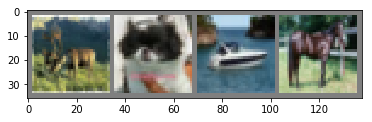

In [9]:
imshow(torchvision.utils.make_grid(images))
print(' '.join('%5s' % classes[labels[j]] for j in range(4)))

In [10]:
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.conv1 = nn.Conv2d(3, 6, 5)
        self.pool = nn.MaxPool2d(2, 2)
        self.conv2 = nn.Conv2d(6, 16, 5)
        self.fc1 = nn.Linear(16 * 5 * 5, 120)
        self.fc2 = nn.Linear(120, 84)
        self.fc3 = nn.Linear(84, 10)

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = x.view(-1, 16 * 5 * 5)
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x

In [11]:
net = Net()
net = net.to(device)

In [12]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(net.parameters(), lr=0.001, momentum=0.9)

In [13]:
for epoch in range(2):  # loop over the dataset multiple times

    running_loss = 0.0
    t_0 = time.time()
    for i, data in enumerate(trainloader, 0):
        # get the inputs
        inputs, labels = data
        inputs = inputs.to(device)
        labels = labels.to(device)
        # zero the parameter gradients
        optimizer.zero_grad()

        # forward + backward + optimize
        outputs = net(inputs)
        print(outputs.shape, labels.shape)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        # print statistics
        running_loss += loss.item()
        if i % 2000 == 1999:    # print every 2000 mini-batches
            t_1 = time.time()
            print('[%d, %5d] loss: %.3f time: %.3f' %
                  (epoch + 1, i + 1, running_loss / 2000, t_1-t_0))
            t_0 = time.time()
            running_loss = 0.0

print('Finished Training')

torch.Size([4, 10]) torch.Size([4])
torch.Size([4, 10]) torch.Size([4])
torch.Size([4, 10]) torch.Size([4])
torch.Size([4, 10]) torch.Size([4])
torch.Size([4, 10]) torch.Size([4])
torch.Size([4, 10]) torch.Size([4])
torch.Size([4, 10]) torch.Size([4])
torch.Size([4, 10]) torch.Size([4])
torch.Size([4, 10]) torch.Size([4])
torch.Size([4, 10]) torch.Size([4])
torch.Size([4, 10]) torch.Size([4])
torch.Size([4, 10]) torch.Size([4])
torch.Size([4, 10]) torch.Size([4])
torch.Size([4, 10]) torch.Size([4])
torch.Size([4, 10]) torch.Size([4])
torch.Size([4, 10]) torch.Size([4])
torch.Size([4, 10]) torch.Size([4])
torch.Size([4, 10]) torch.Size([4])
torch.Size([4, 10]) torch.Size([4])
torch.Size([4, 10]) torch.Size([4])
torch.Size([4, 10]) torch.Size([4])
torch.Size([4, 10]) torch.Size([4])
torch.Size([4, 10]) torch.Size([4])
torch.Size([4, 10]) torch.Size([4])
torch.Size([4, 10]) torch.Size([4])
torch.Size([4, 10]) torch.Size([4])
torch.Size([4, 10]) torch.Size([4])
torch.Size([4, 10]) torch.Si

Process Process-3:
Exception ignored in: <bound method Image.__del__ of <PIL.Image.Image image mode=RGB size=32x32 at 0x7FCCFC3DD908>>
Traceback (most recent call last):
Traceback (most recent call last):
  File "/is/sg/mniemeyer/.local/lib/python3.6/site-packages/PIL/Image.py", line 602, in __del__
  File "/usr/lib/python3.6/multiprocessing/process.py", line 258, in _bootstrap
    self.run()
  File "/usr/lib/python3.6/multiprocessing/process.py", line 93, in run
    self._target(*self._args, **self._kwargs)
ERROR:root:Internal Python error in the inspect module.
Below is the traceback from this internal error.

    if (hasattr(self, 'fp') and hasattr(self, '_exclusive_fp')
  File "/is/sg/mniemeyer/.local/lib/python3.6/site-packages/torch/utils/data/dataloader.py", line 96, in _worker_loop
    r = index_queue.get(timeout=MANAGER_STATUS_CHECK_INTERVAL)
KeyboardInterrupt
  File "/usr/lib/python3.6/multiprocessing/queues.py", line 104, in get
    if not self._poll(timeout):
  File "/usr/l

torch.Size([4, 10]) torch.Size([4])
Traceback (most recent call last):
  File "/usr/lib/python3/dist-packages/IPython/core/interactiveshell.py", line 2882, in run_code
    exec(code_obj, self.user_global_ns, self.user_ns)
  File "<ipython-input-13-c926682983d2>", line 14, in <module>
    outputs = net(inputs)
  File "/is/sg/mniemeyer/.local/lib/python3.6/site-packages/torch/nn/modules/module.py", line 477, in __call__
    result = self.forward(*input, **kwargs)
  File "<ipython-input-10-0408d9e1a14c>", line 17, in forward
    x = self.fc3(x)
  File "/is/sg/mniemeyer/.local/lib/python3.6/site-packages/torch/nn/modules/module.py", line 477, in __call__
    result = self.forward(*input, **kwargs)
  File "/is/sg/mniemeyer/.local/lib/python3.6/site-packages/torch/nn/modules/linear.py", line 55, in forward
    return F.linear(input, self.weight, self.bias)
  File "/is/sg/mniemeyer/.local/lib/python3.6/site-packages/torch/nn/functional.py", line 1024, in linear
    return torch.addmm(bias, in

KeyboardInterrupt: 

In [20]:
testset = torchvision.datasets.CIFAR10(root='./data', train=False,
                                       download=True, transform=transform)
testloader = torch.utils.data.DataLoader(testset, batch_size=4,
                                         shuffle=False, num_workers=2)

Files already downloaded and verified


In [21]:
dataiter = iter(testloader)
images, labels = dataiter.next()

GroundTruth:    cat  ship  ship plane


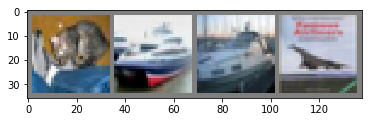

In [22]:
imshow(torchvision.utils.make_grid(images))
print('GroundTruth: ', ' '.join('%5s' % classes[labels[j]] for j in range(4)))

In [23]:
images = images.to(device)

In [24]:
outputs = net(images)

In [25]:
_, predicted = torch.max(outputs, 1)
print('Predicted: ', ' '.join('%5s' % classes[predicted[j]]
                             for j in range(4)))

Predicted:   frog  ship  ship  ship


In [26]:
correct = 0
total = 0
with torch.no_grad():
    for data in testloader:
        images, labels = data
        images = images.to(device)
        labels = labels.to(device)
        
        outputs = net(images)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

In [27]:
print('Acc of the net on the 10k test imgs: %d %%' % (100 * correct / total))

Acc of the net on the 10k test imgs: 55 %


In [28]:
class_correct = list(0. for i in range(10))
class_total = list(0. for i in range(10))
with torch.no_grad():
    for data in testloader:
        images, labels = data
        images = images.to(device)
        labels = labels.to(device)
        outputs = net(images)
        _, predicted = torch.max(outputs, 1)
        c = (predicted == labels).squeeze()
        for i in range(4):
            label = labels[i]
            class_correct[label] += c[i].item()
            class_total[label] += 1

In [29]:
for i in range(10):
    print('Acc of %5s: %2d %%' % (
        classes[i], 100 * class_correct[i] / class_total[i]))

Acc of plane: 70 %
Acc of   car: 56 %
Acc of  bird: 41 %
Acc of   cat: 17 %
Acc of  deer: 50 %
Acc of   dog: 52 %
Acc of  frog: 71 %
Acc of horse: 64 %
Acc of  ship: 81 %
Acc of truck: 55 %
